In [385]:
# importing all the required libraries

import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

# Importing and splitting the data into training and testing

In [386]:
# importing the file with the combined data of both the hospitals and splitting it into 2 parts

combined = pd.read_csv('/content/Dataset.csv')

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) == 6)]
df_train = combined.drop(rows_to_drop.index)
df_train.to_csv('data_part1.csv', index=False)

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) != 6)]
df_test = combined.drop(rows_to_drop.index)
df_test.to_csv('data_part2.csv', index=False)

In [387]:
# importing the test and training data

df_train = pd.read_csv('/content/data_part1.csv')
df_test = pd.read_csv('/content/data_part2.csv')

# Exploratory data analysis

In [388]:
df_train.head(15)

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,1,0,17072
1,1,1,65.0,100.0,NaN,NaN,72.0,NaN,16.5,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,2,0,17072
2,2,2,78.0,100.0,NaN,NaN,42.5,NaN,NaN,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,3,0,17072
3,3,3,73.0,100.0,NaN,NaN,NaN,NaN,17.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,4,0,17072
4,4,4,70.0,100.0,NaN,129.0,74.0,69.0,14.0,NaN,...,NaN,330.0,68.54,0,NaN,NaN,-0.02,5,0,17072
5,5,5,62.0,100.0,NaN,124.0,85.0,61.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,6,0,17072
6,6,6,61.0,100.0,NaN,101.0,75.0,58.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,7,0,17072
7,7,7,68.0,100.0,35.78,142.0,93.5,78.0,16.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,8,0,17072
8,8,8,71.0,100.0,NaN,121.0,74.0,91.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,9,0,17072
9,9,9,69.0,100.0,NaN,120.0,79.0,98.0,14.0,NaN,...,NaN,NaN,68.54,0,NaN,NaN,-0.02,10,0,17072


As can be seen, this is a time series data. The dataframe has 44 columns. After the first loook at data, it can be observed that the data seems quite sparse.

In [389]:
# let's list down all the different columns

df_train.columns

Index(['Unnamed: 0', 'Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP',
       'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2',
       'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine',
       'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate',
       'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID'],
      dtype='object')

In [390]:
# list of all the unique patients
# total number of patients present in the dataset

patients = list(df_test['Patient_ID'].unique())
len(patients)

20000

In [391]:
# Function to draw correlation heat map 

def corr_matrix(df):
  corr = df.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  f, ax = plt.subplots(figsize=(40,40))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap="Paired", vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [392]:
# Percentage of null values present in all the parameters 

null_values = df_train.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

EtCO2               100.000000
TroponinI            99.877881
Bilirubin_direct     99.850420
Fibrinogen           99.236917
Bilirubin_total      98.773372
Alkalinephos         98.540650
AST                  98.504205
Lactate              96.565112
PTT                  95.152459
SaO2                 95.044387
Calcium              95.024392
Phosphate            94.951247
Platelets            93.482913
Creatinine           93.357884
WBC                  92.489639
Magnesium            92.219712
HCO3                 91.949406
BUN                  91.840702
Chloride             91.676063
PaCO2                91.231753
Hgb                  91.164303
BaseExcess           89.574863
Potassium            89.137640
pH                   88.532868
Hct                  88.223711
Glucose              87.768392
FiO2                 85.807027
Temp                 66.224255
Unit1                48.868346
Unit2                48.868346
DBP                  48.125763
SBP                  15.211177
O2Sat   


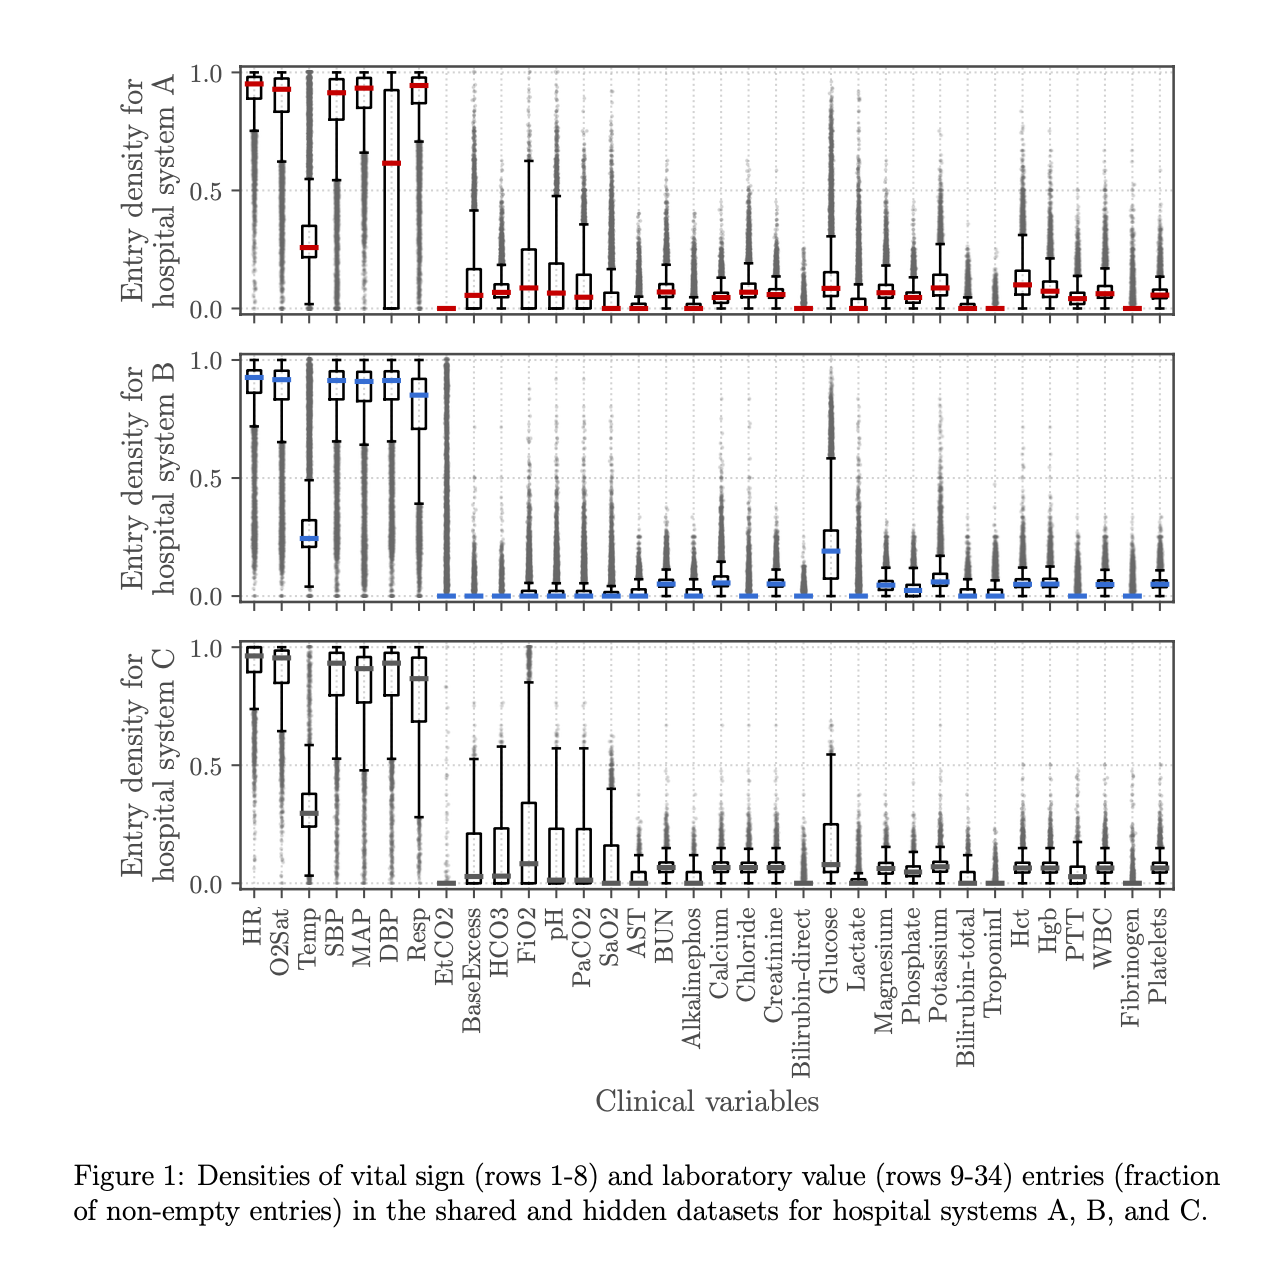

Image obtained from the official pdf of the PhysioNet Challenge. The image gives an overall idea of the number of records available for each feature, for all the three datasets of three different hospitals.

After thorough analysis of the data, it was found that a lot of the features were redundant, i.e. a lot of the features were indicative of the same parameter, so those features were removed on the basis of their sparsity. Another criteria taken into consideration was ease of getting the parameter among different hospitals, becuase some of the parameters are easier to obtain for a given hospital while some are expensive and for some a hospital does not even have infrastructure to get those features.

In [393]:
# the features have been removed based on the number of null values and redundancy 

# 'Unnamed: 0'-- this is the index column
# 'SBP' -- MAP is considered instead of SBP and DBP
# 'DBP' -- MAP is considered instead of SBP and DBP
# 'EtCO2' -- It is not readily. available and also not available in the dataset
# 'BaseExcess' -- It is an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here. 
# 'HCO3' -- It is also an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'pH' -- It is also an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'PaCO2' -- It is an indicator of respiratory health of an individual, we are considering SaO2 and FiO2 which are more readily avaiilable
# 'Alkalinephos' -- It is an indicator of the health of the liver of an individual, but we are considering Bilirubin instead of this, as data of this is more scarce.
# 'Calcium' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'Magnesium' -- It is an indicator of metabolism and kidney health, but we are considering Lactate instead as it is more readily available
# 'Phosphate' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'Potassium' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'PTT' -- It is used to check inflammation. We are using WBC counts instead as it is easy to obtain.
# 'Fibrinogen' -- It is used to check blood clotting ability. We are using Platelets instead, as it is easier to obtain.
# 'Unit1' -- Both the columns Unit1 and Unit2 have been merged to form a single column.
# 'Unit2' -- Both the columns Unit1 and Unit2 have been merged to form a single column.

columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium', 
'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
df_train = df_train.assign(Unit=df_train['Unit1'] + df_train['Unit2'])
df_train_mod = df_train.drop(columns=columns_drop)
df_train_mod.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'FiO2', 'SaO2', 'AST',
       'BUN', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'WBC',
       'Platelets', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel',
       'Patient_ID', 'Unit'],
      dtype='object')

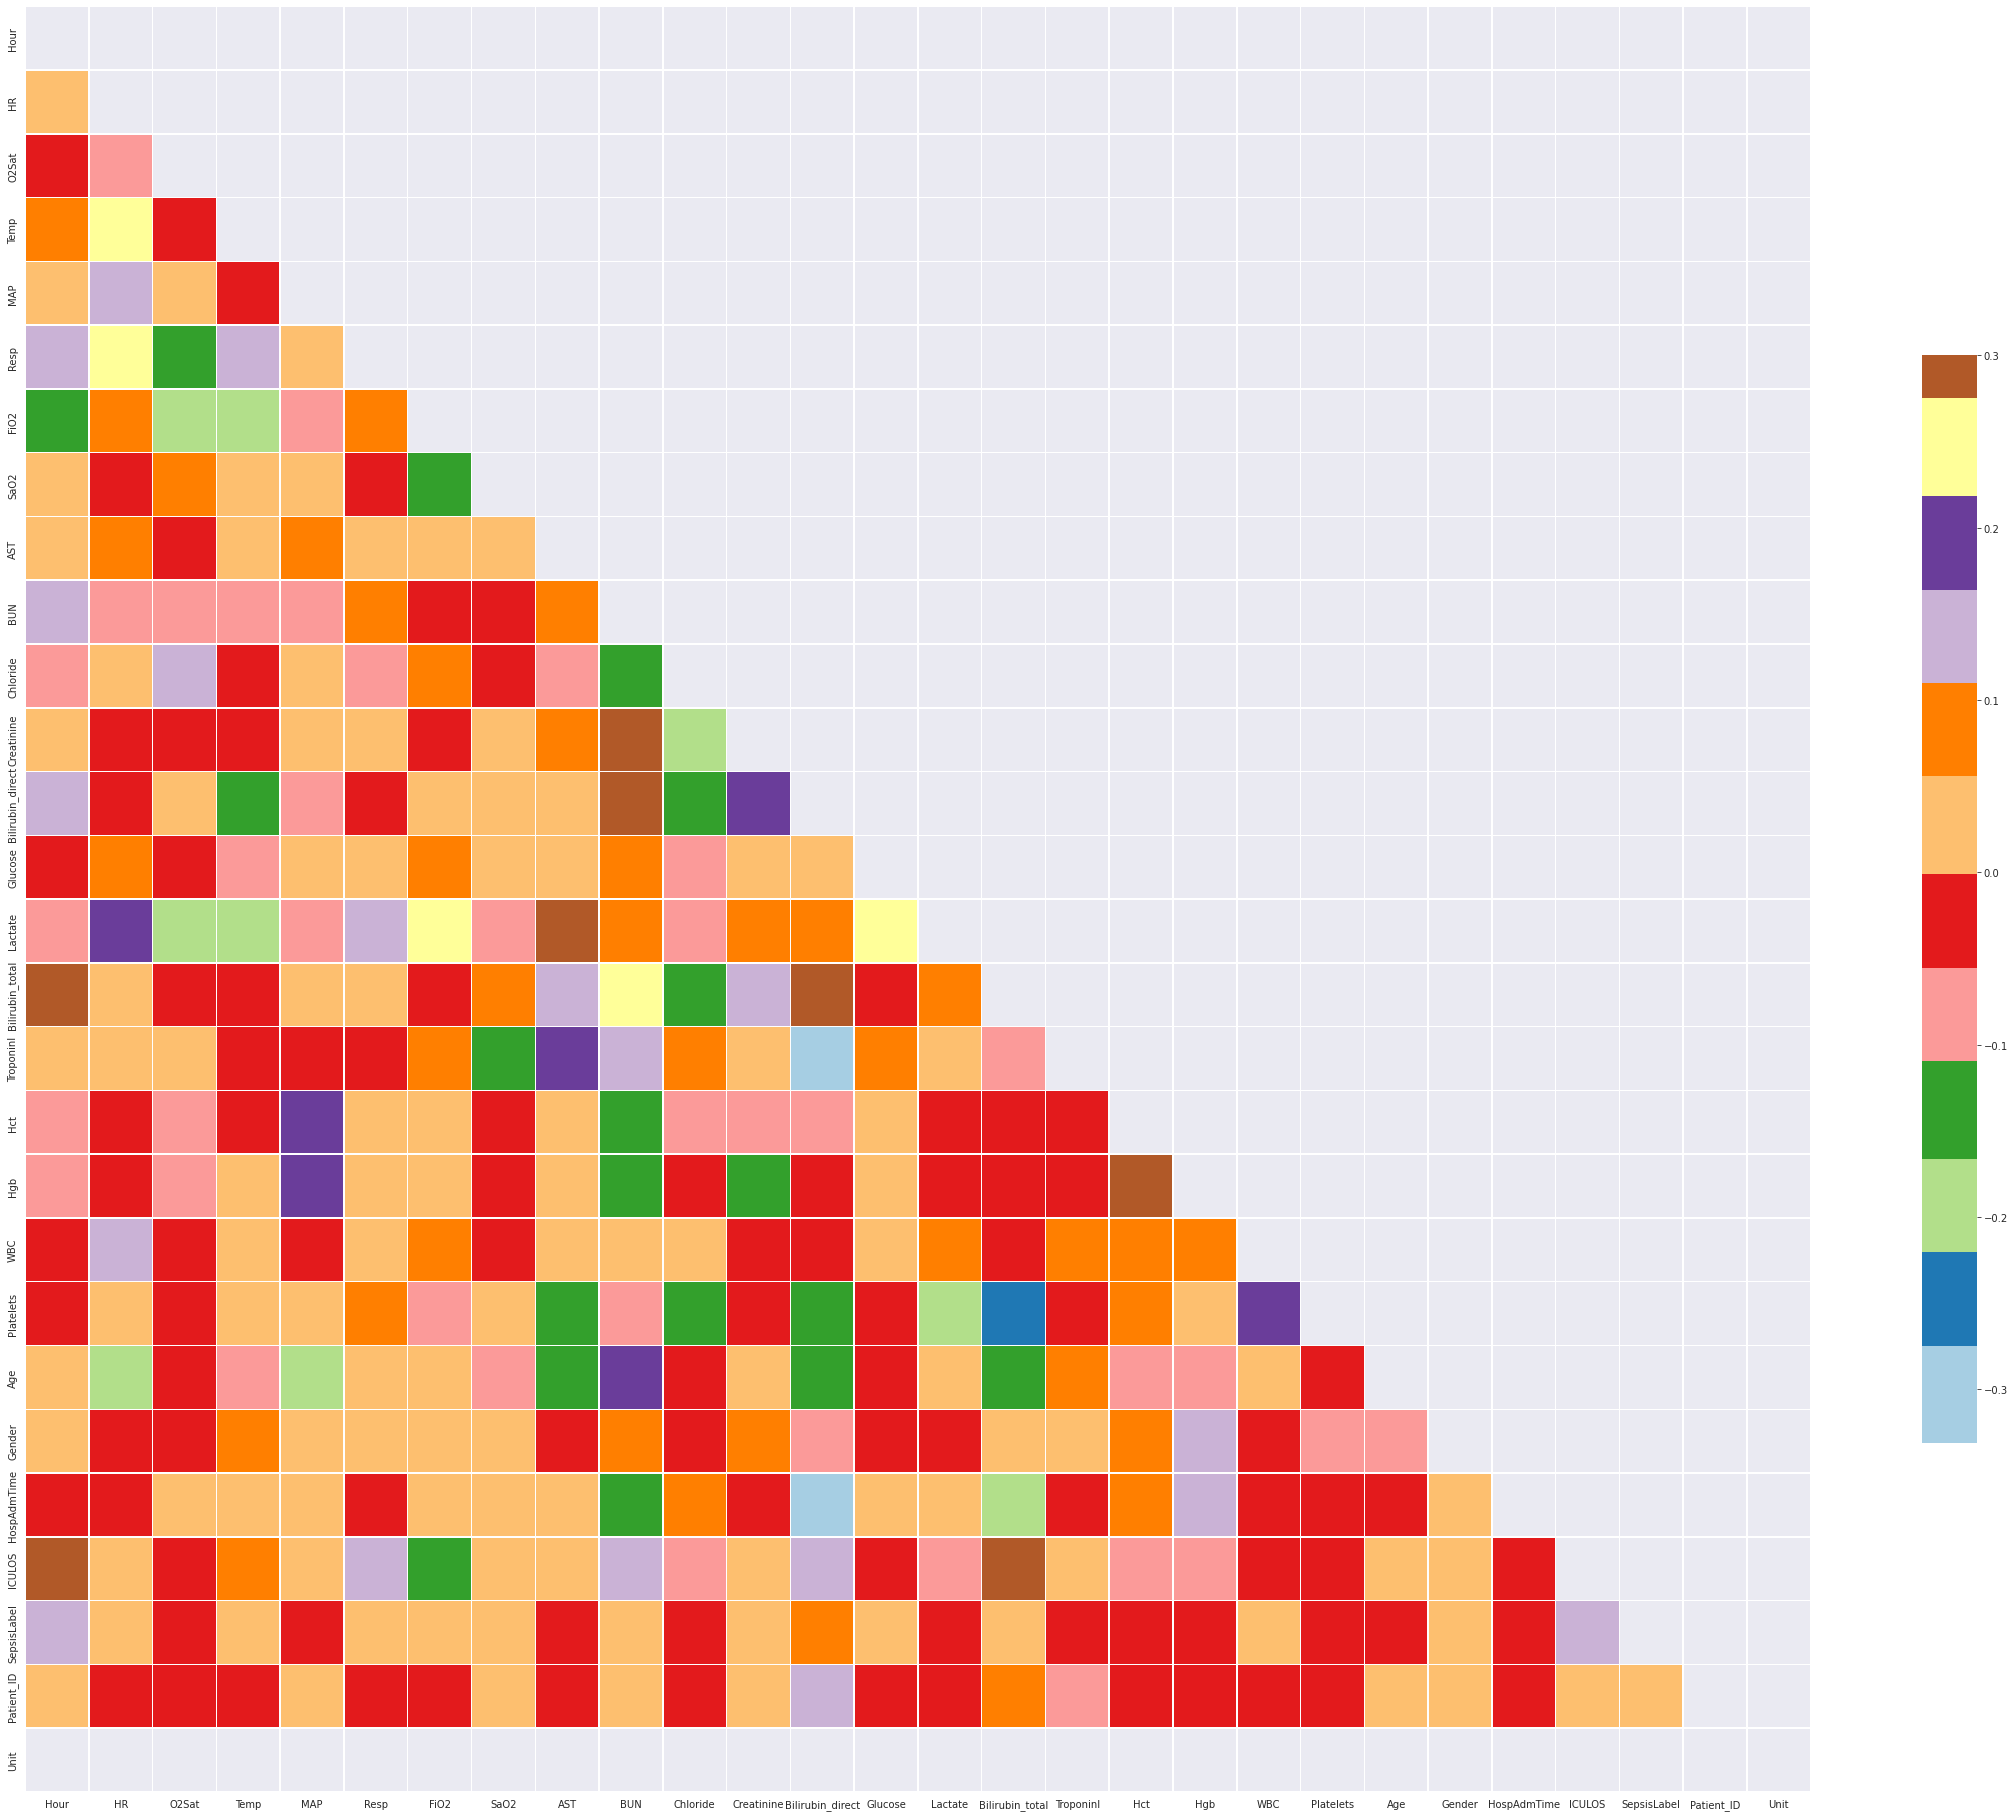

In [394]:
# correlation matrix to check if there is high correlation between the remaining features

corr_matrix(df_train_mod)

As can be seen in this correlation heat map almost all of the feature do not have high correlation.

# Imputation

Since there are a lot of missing values in the dataset, therefore imputation was done to fill the missing values. While imputing, it is important to note that ***imputation should be done on per patient basis,*** otherwise the data from one patient will leak into the data of the other patient. Also another point that should be taken into consideration is that mean, median, mode can not directly be used to impute as it will result in uneven distribution of the parameters with respect to time.

In [395]:
df_train_impute = df_train_mod.copy()
columns_impute = list(df_train_impute.columns)

In [396]:
# bfill and ffill for imputing

grouped_by_patient = df_train_impute.groupby('Patient_ID')
df_train_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())

In [397]:
df_train_impute.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,FiO2,SaO2,AST,BUN,...,Hgb,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,Patient_ID,Unit
0,0,65.0,100.0,35.78,72.0,16.5,0.4,NaN,29.0,23.0,...,9.5,11.3,330.0,68.54,0,-0.02,1,0,17072,NaN
1,1,65.0,100.0,35.78,72.0,16.5,0.4,NaN,29.0,23.0,...,9.5,11.3,330.0,68.54,0,-0.02,2,0,17072,NaN
2,2,78.0,100.0,35.78,42.5,17.0,0.4,NaN,29.0,23.0,...,9.5,11.3,330.0,68.54,0,-0.02,3,0,17072,NaN
3,3,73.0,100.0,35.78,74.0,17.0,0.4,NaN,29.0,23.0,...,9.5,11.3,330.0,68.54,0,-0.02,4,0,17072,NaN
4,4,70.0,100.0,35.78,74.0,14.0,0.4,NaN,29.0,23.0,...,9.5,11.3,330.0,68.54,0,-0.02,5,0,17072,NaN


In [398]:
# Now let's check the remaining proportion of missing values

null_values = df_train_impute.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

TroponinI           97.357934
Bilirubin_direct    96.256841
Bilirubin_total     66.949754
AST                 66.435590
SaO2                57.282891
Lactate             55.997418
Unit                48.868346
FiO2                36.195592
WBC                  1.511994
Platelets            1.394810
Chloride             1.310656
Hgb                  1.158672
Creatinine           1.029467
Glucose              0.940630
BUN                  0.937719
Temp                 0.853692
Hct                  0.779028
Resp                 0.088710
O2Sat                0.026702
MAP                  0.003037
HR                   0.001139
HospAdmTime          0.001012
Age                  0.000000
Gender               0.000000
ICULOS               0.000000
SepsisLabel          0.000000
Patient_ID           0.000000
Hour                 0.000000
dtype: float64

'TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2', 'Unit', 'Patient_ID'  have more than 25 percent of null values and hence are dropped from the dataset. 

In [399]:
# dropping all the columns with null values more than 25% and patient_id

null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2',
            'Unit', 'Patient_ID']
df_train_impute = df_train_impute.drop(columns=null_col)
df_train_impute.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [400]:
# onehot encoding the gender

one_hot = pd.get_dummies(df_train_impute['Gender'])
df_train_impute = df_train_impute.join(one_hot)
df_train_impute = df_train_impute.drop('Gender', axis=1)


## Gaussian Transformation and Standard Normalization

Generally models tend to give a better result for a normal ditribution. So in the below cells we explored different techniques to plot histograms and QQ plots of all the features and then we applied different transformations on it to see which were giving good results. The ones giving the beest results were then adopted in the dataframe.

In [401]:
# function to draw histogram and QQ plot 

def diagnostic_plots(df, variable):
    fig = plt.figure(figsize=(15,4))
    ax = fig.add_subplot(121)
    df[variable].hist(bins=30)
    ax = fig.add_subplot(122)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.xlabel(variable)
    plt.show()

In [402]:
# function to apply different transformations to make the plot gaussian

def try_gaussian(df, col):
  print('actual plot')
  diagnostic_plots(df,col)
  # this applies yeojohnson plot
  df['col_yj'], param = stats.yeojohnson(df[col]) 
  print('yeojohnson plot')
  diagnostic_plots(df, 'col_yj')
  # this applies exponential transformation
  df['col_1.5'] = df[col]**(1/1.5)
  print('**1/1.5 plot') 
  diagnostic_plots(df, 'col_1.5')
  df['col_.5'] = df[col]**(.5)
  print('**.5 plot') 
  # this applies inverse transformation
  diagnostic_plots(df, 'col_.5')
  df['col_rec'] = 1 / (df[col]+0.00001) 
  diagnostic_plots(df, 'col_rec')
  # this applies logarithmic trasnformation
  df['col_log'] = np.log(df[col]+1)
  diagnostic_plots(df, 'col_log')    


O2Sat
actual plot


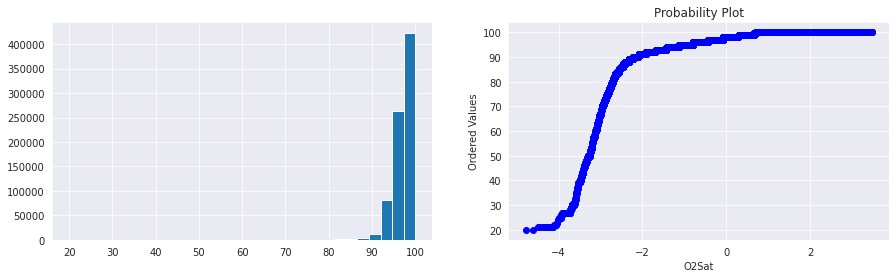

yeojohnson plot


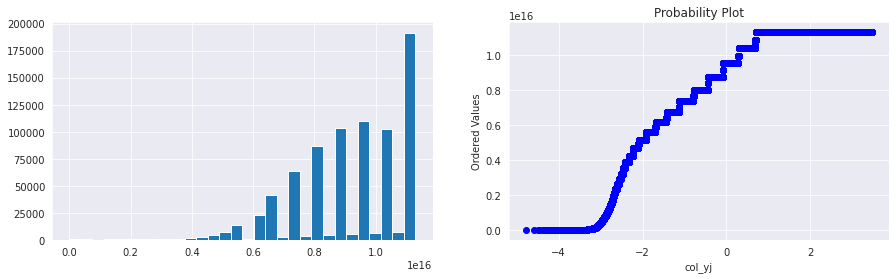

**1/1.5 plot


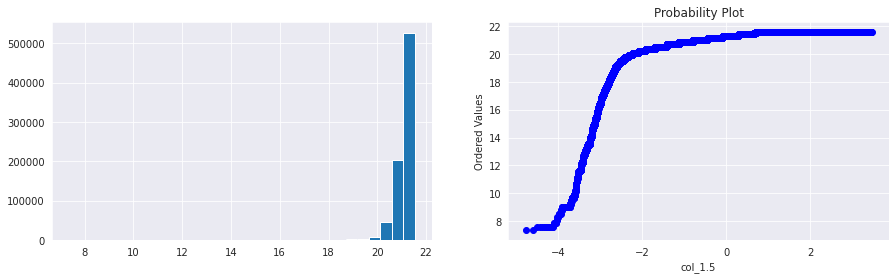

**.5 plot


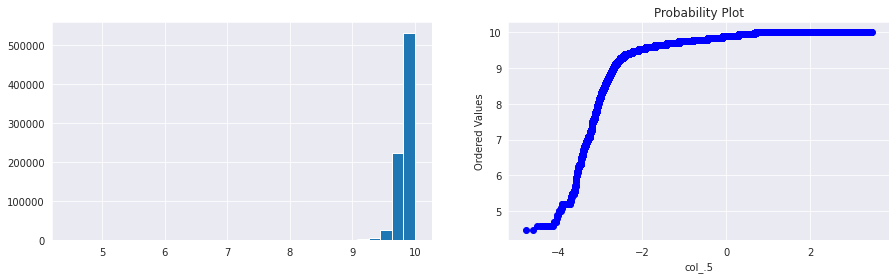

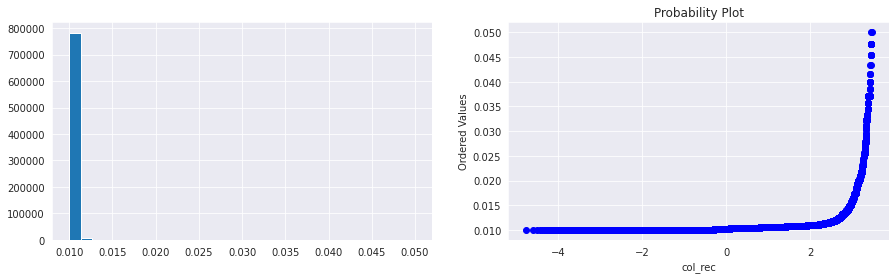

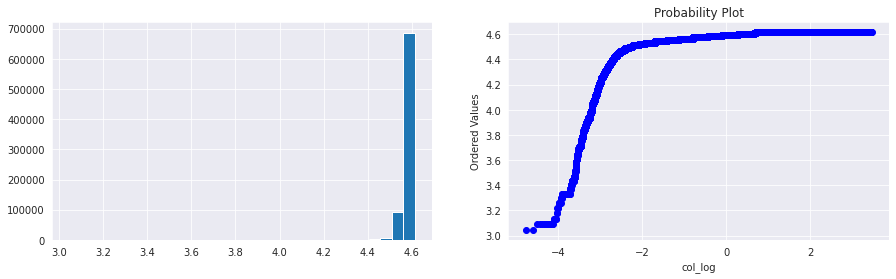

Temp
actual plot


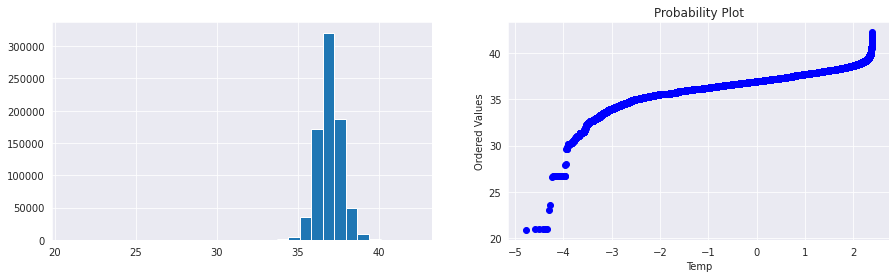

yeojohnson plot


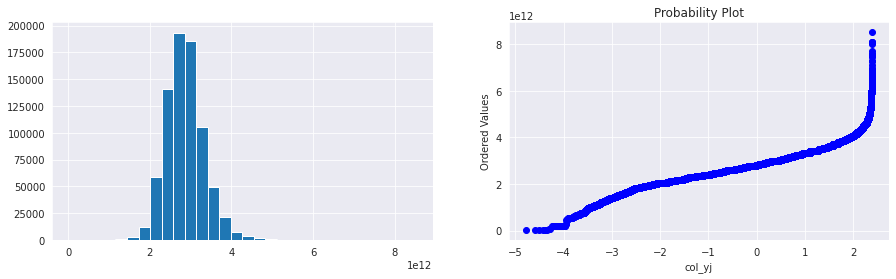

**1/1.5 plot


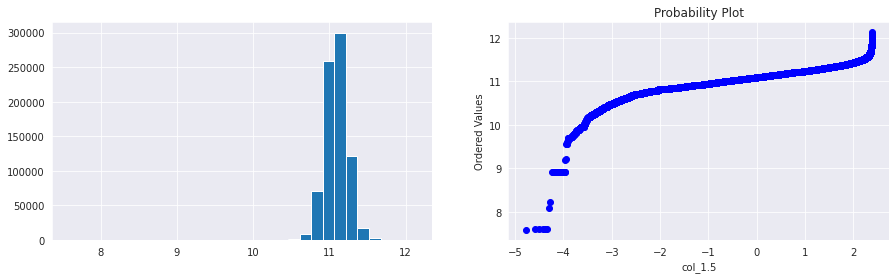

**.5 plot


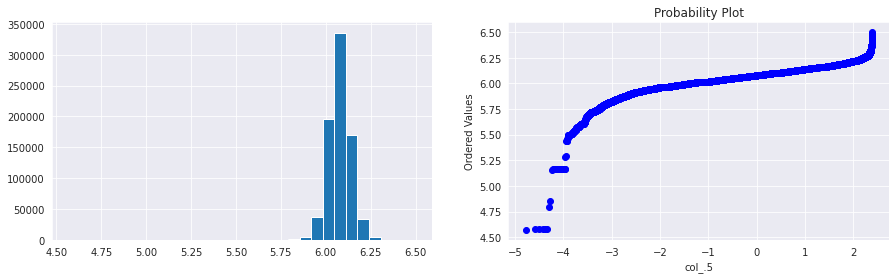

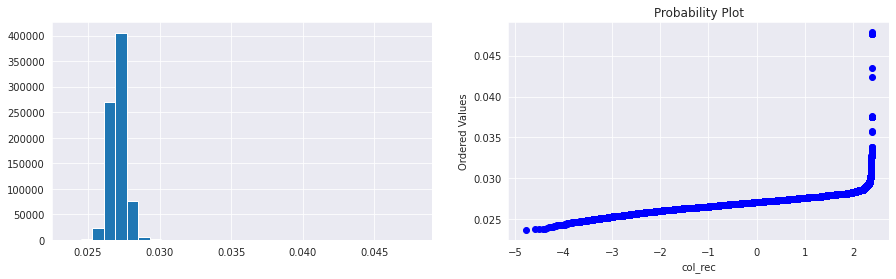

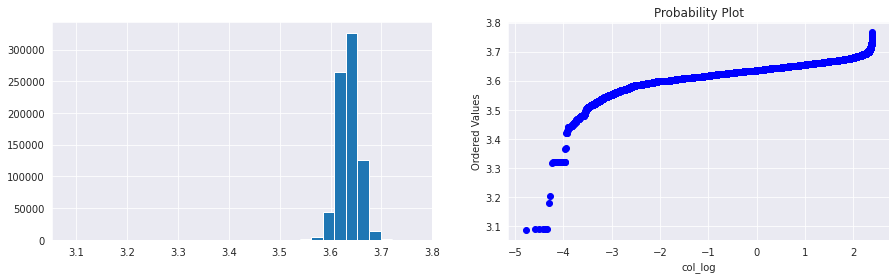

MAP
actual plot


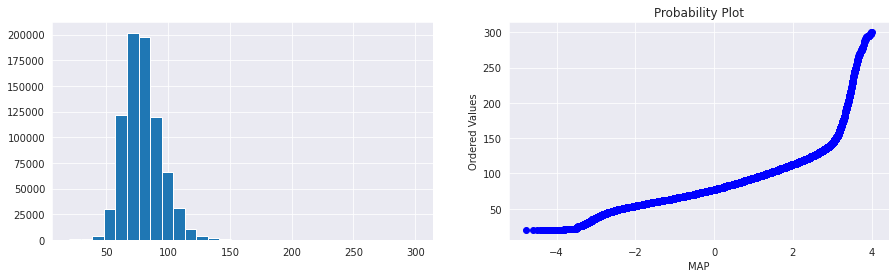

yeojohnson plot


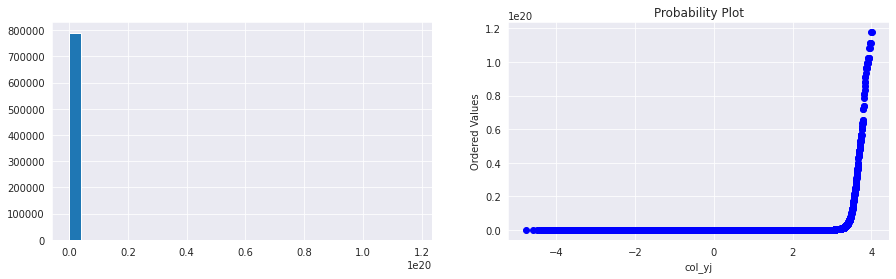

**1/1.5 plot


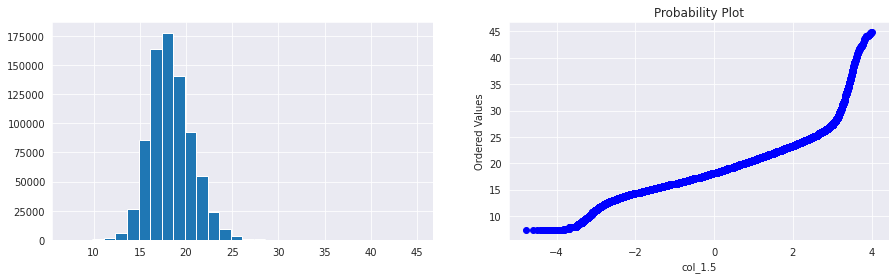

**.5 plot


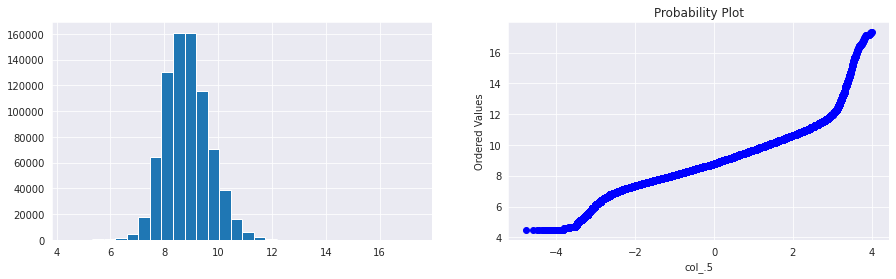

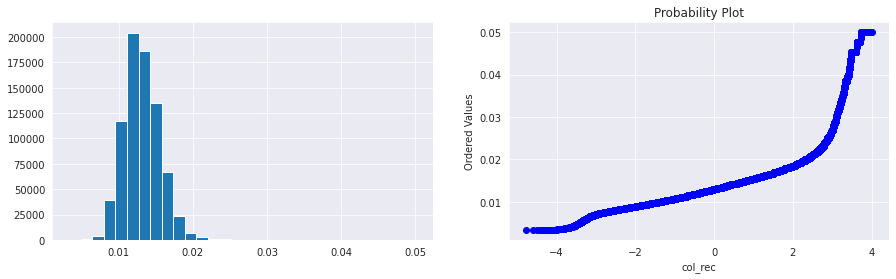

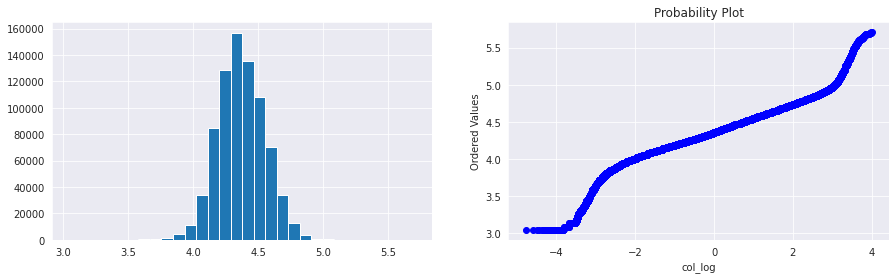

BUN
actual plot


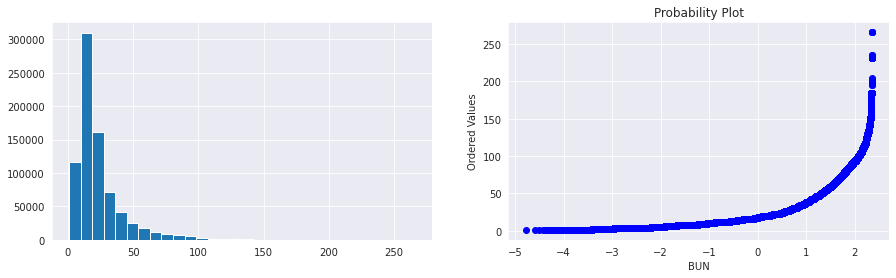

yeojohnson plot


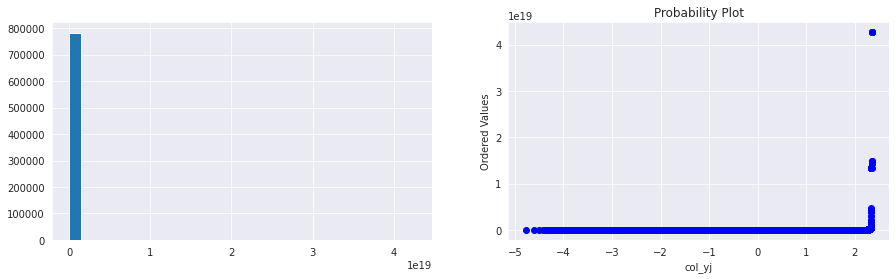

**1/1.5 plot


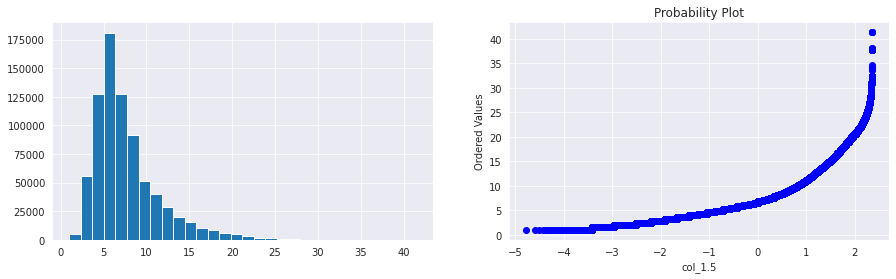

**.5 plot


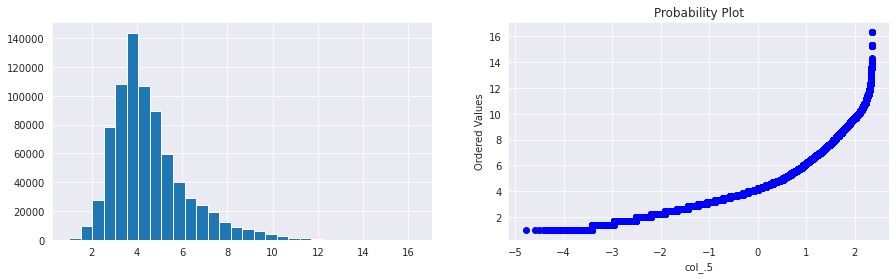

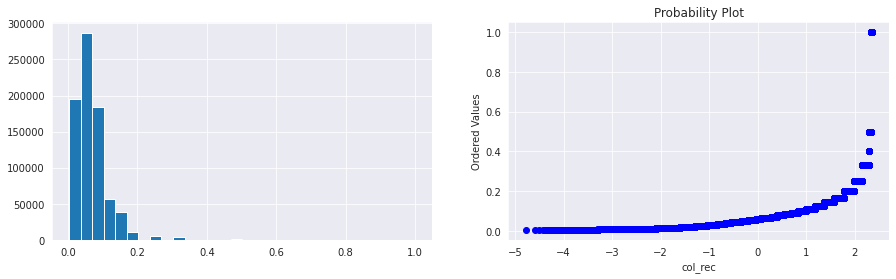

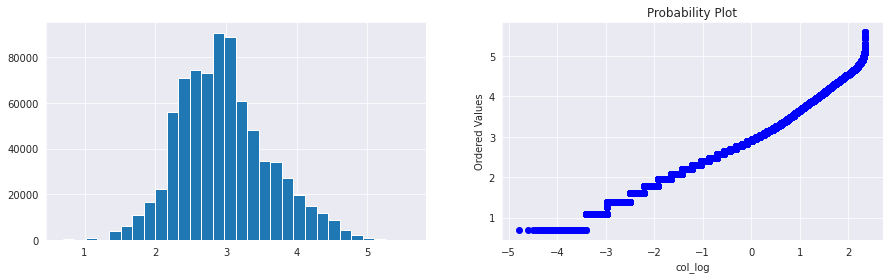

Creatinine
actual plot


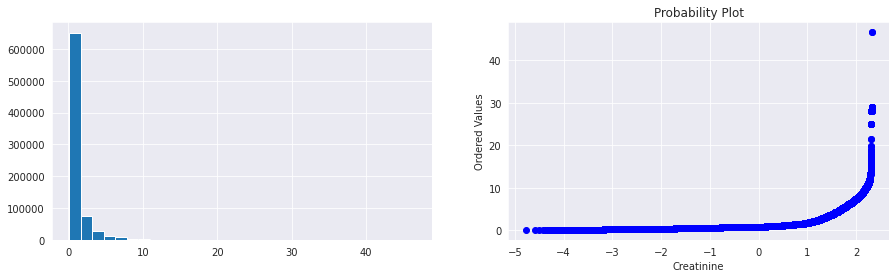

yeojohnson plot


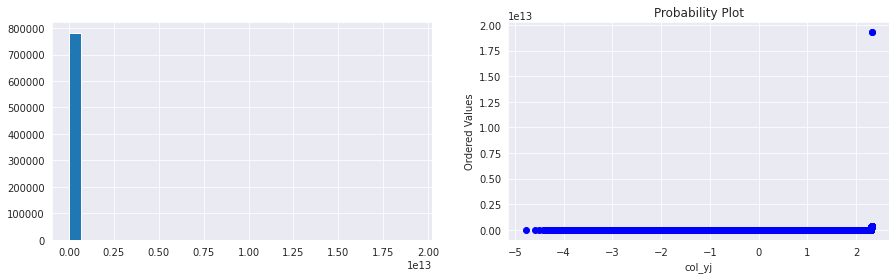

**1/1.5 plot


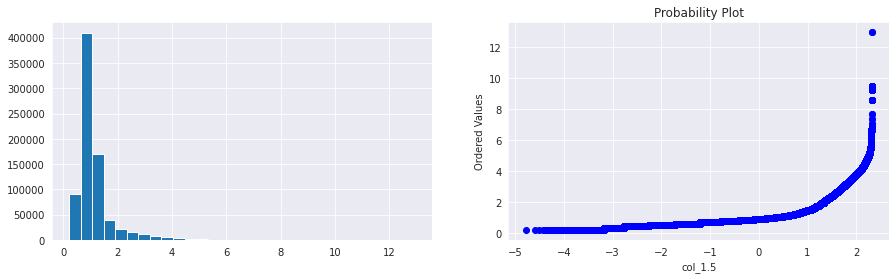

**.5 plot


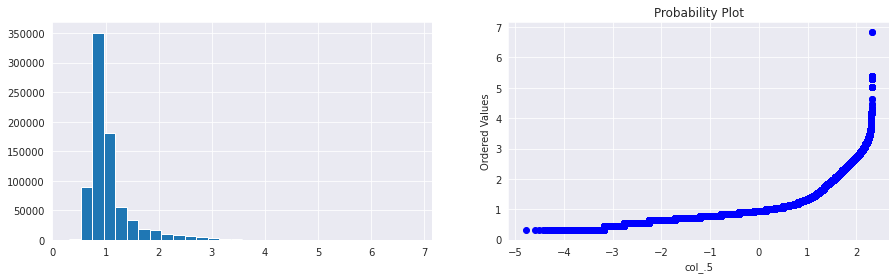

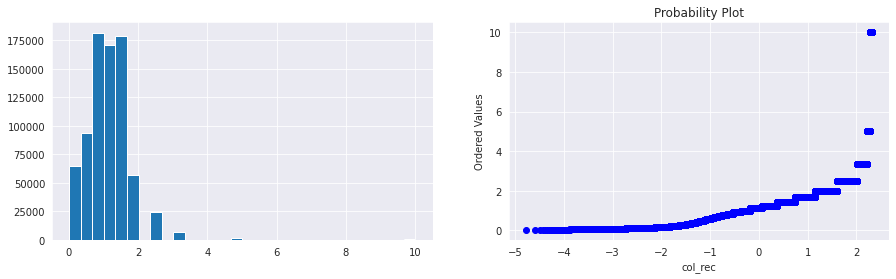

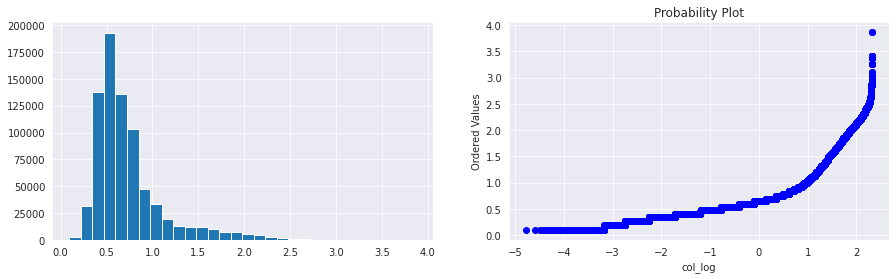

Glucose
actual plot


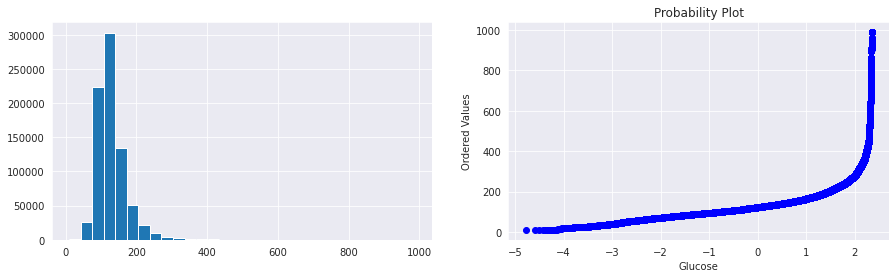

yeojohnson plot


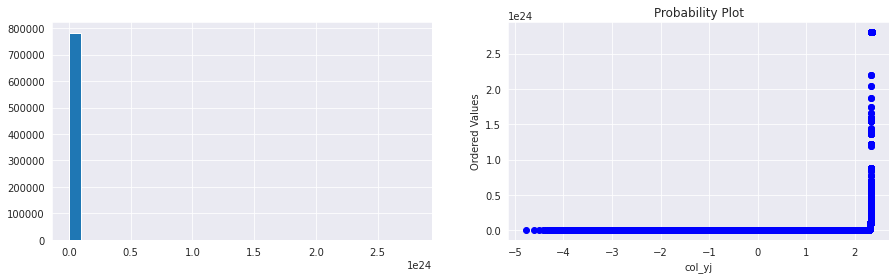

**1/1.5 plot


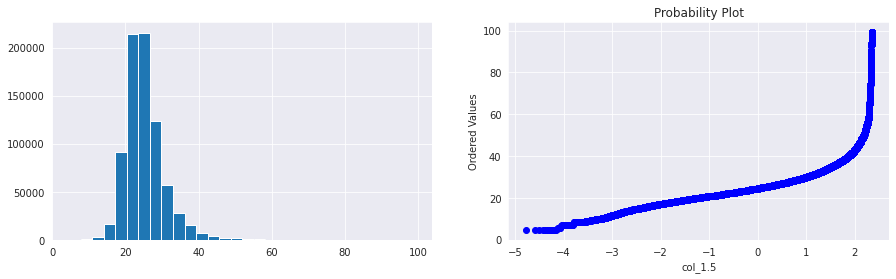

**.5 plot


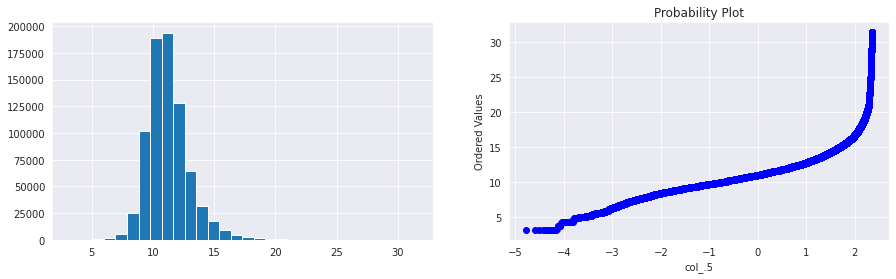

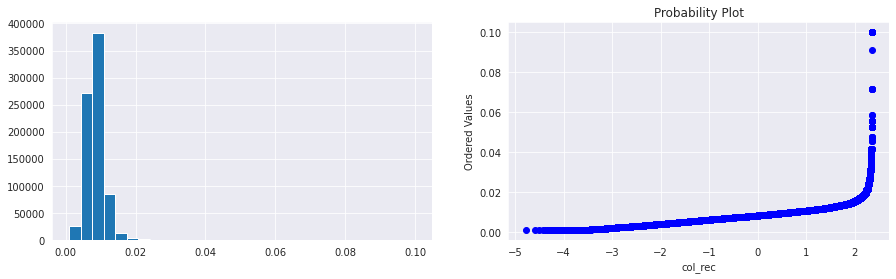

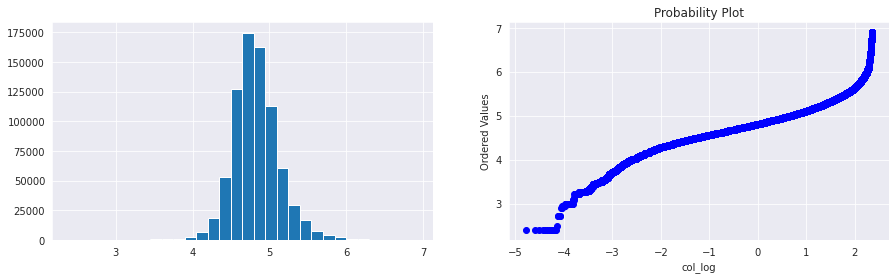

WBC
actual plot


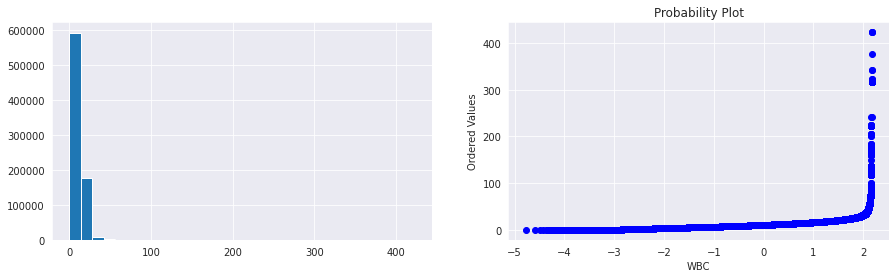

yeojohnson plot


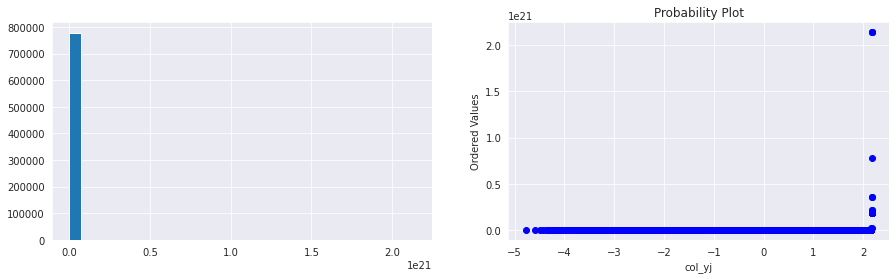

**1/1.5 plot


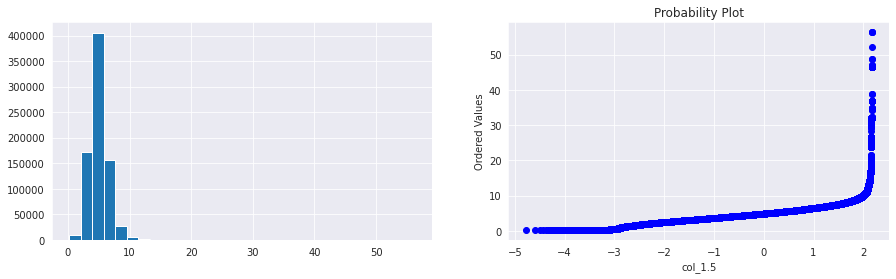

**.5 plot


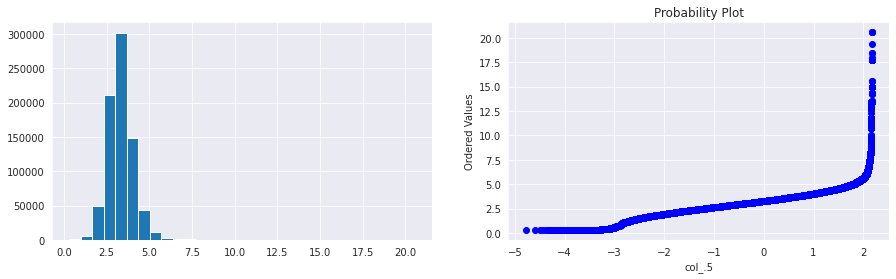

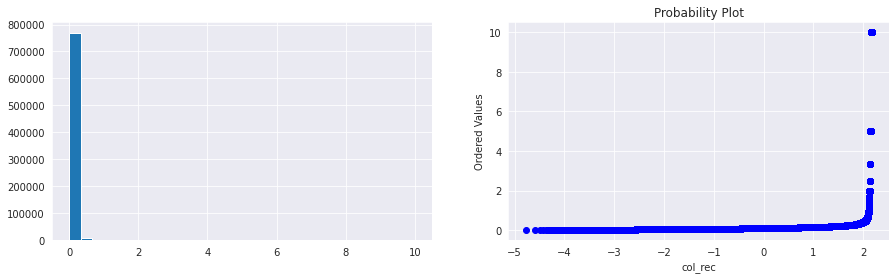

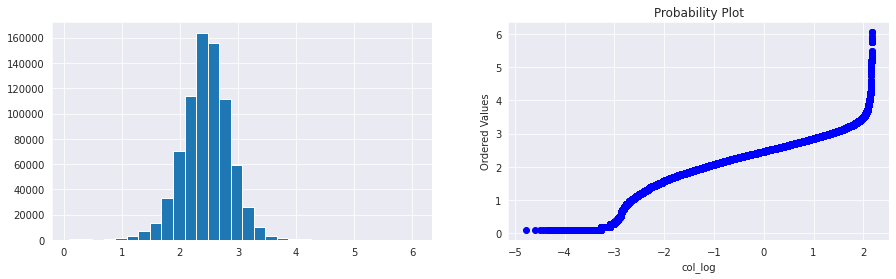

Platelets
actual plot


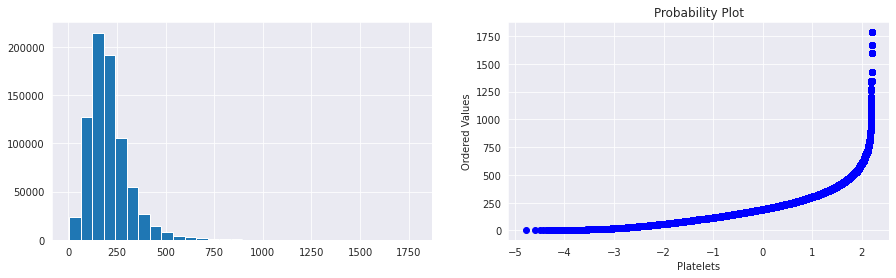

yeojohnson plot


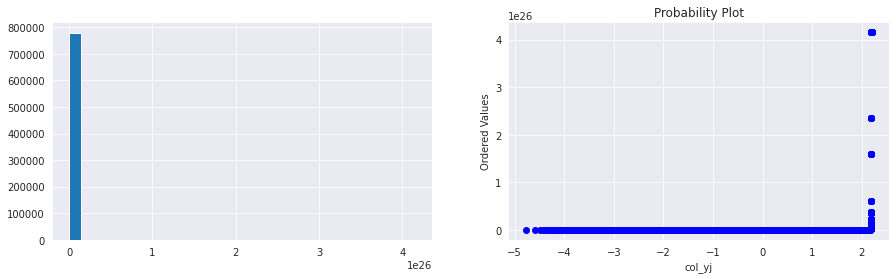

**1/1.5 plot


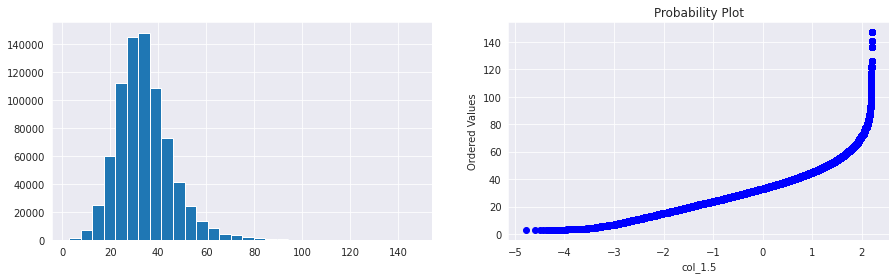

**.5 plot


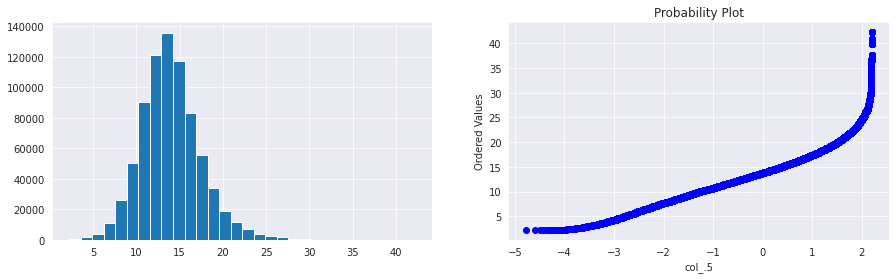

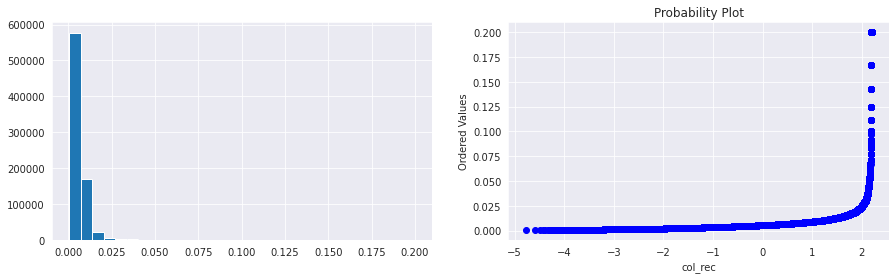

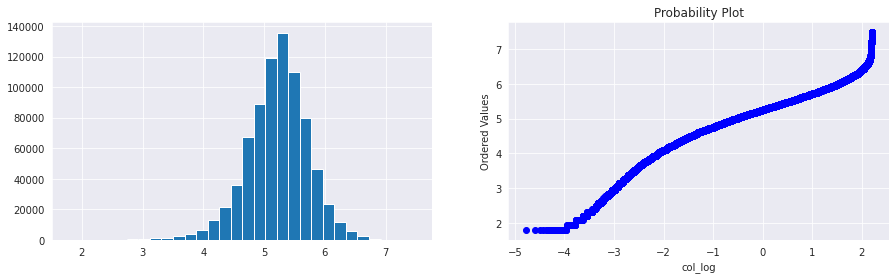

In [403]:
# try normal distribution
# Now we try to check the distribution of values present in different columns after application of various transformations

lst = ['O2Sat', 'Temp', 'MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in lst:
  print(i)
  try_gaussian(df_train_impute, i)

In [404]:
# after application of the above code, some redundant columns got added to the dataframe, which are removed through this line of code

df_train_impute = df_train_impute.drop(columns = ['col_yj','col_1.5','col_.5','col_rec','col_log'])

In [405]:
df_train_impute.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Chloride,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,SepsisLabel,0,1
0,0,65.0,100.0,35.78,72.0,16.5,23.0,104.0,0.8,161.0,29.7,9.5,11.3,330.0,68.54,-0.02,1,0,1,0
1,1,65.0,100.0,35.78,72.0,16.5,23.0,104.0,0.8,161.0,29.7,9.5,11.3,330.0,68.54,-0.02,2,0,1,0
2,2,78.0,100.0,35.78,42.5,17.0,23.0,104.0,0.8,161.0,29.7,9.5,11.3,330.0,68.54,-0.02,3,0,1,0
3,3,73.0,100.0,35.78,74.0,17.0,23.0,104.0,0.8,161.0,29.7,9.5,11.3,330.0,68.54,-0.02,4,0,1,0
4,4,70.0,100.0,35.78,74.0,14.0,23.0,104.0,0.8,161.0,29.7,9.5,11.3,330.0,68.54,-0.02,5,0,1,0


In [406]:
# by oserving different plots, it can be concluded that only log was somewhat effective and that too for MAP, BUN, Creatinine, Glucose, WBC & Plateletes
# therefore applying log transformations on the above columns

columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in columns_normalized:
  df_train_impute[i] = np.log(df_train_impute[i]+1)

In [407]:
df_train_impute.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Chloride,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,SepsisLabel,0,1
0,0,65.0,100.0,35.78,4.290459,16.5,3.178054,104.0,0.587787,5.087596,29.7,9.5,2.509599,5.802118,68.54,-0.02,1,0,1,0
1,1,65.0,100.0,35.78,4.290459,16.5,3.178054,104.0,0.587787,5.087596,29.7,9.5,2.509599,5.802118,68.54,-0.02,2,0,1,0
2,2,78.0,100.0,35.78,3.772761,17.0,3.178054,104.0,0.587787,5.087596,29.7,9.5,2.509599,5.802118,68.54,-0.02,3,0,1,0
3,3,73.0,100.0,35.78,4.317488,17.0,3.178054,104.0,0.587787,5.087596,29.7,9.5,2.509599,5.802118,68.54,-0.02,4,0,1,0
4,4,70.0,100.0,35.78,4.317488,14.0,3.178054,104.0,0.587787,5.087596,29.7,9.5,2.509599,5.802118,68.54,-0.02,5,0,1,0


In [408]:
# standard normalization

scaler = StandardScaler()
df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
df_train_impute.head()

,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Chloride,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Age,HospAdmTime,ICULOS,SepsisLabel,0,1
0,0,-1.170030,0.865243,-1.548869,-0.397650,-0.419685,0.322965,-0.226541,-0.410796,0.854631,-0.311111,-0.652538,0.149678,1.140763,68.54,-0.02,1,0,1,0
1,1,-1.170030,0.865243,-1.548869,-0.397650,-0.419685,0.322965,-0.226541,-0.410796,0.854631,-0.311111,-0.652538,0.149678,1.140763,68.54,-0.02,2,0,1,0
2,2,-0.407913,0.865243,-1.548869,-3.187955,-0.326969,0.322965,-0.226541,-0.410796,0.854631,-0.311111,-0.652538,0.149678,1.140763,68.54,-0.02,3,0,1,0
3,3,-0.701035,0.865243,-1.548869,-0.251970,-0.326969,0.322965,-0.226541,-0.410796,0.854631,-0.311111,-0.652538,0.149678,1.140763,68.54,-0.02,4,0,1,0
4,4,-0.876908,0.865243,-1.548869,-0.251970,-0.883265,0.322965,-0.226541,-0.410796,0.854631,-0.311111,-0.652538,0.149678,1.140763,68.54,-0.02,5,0,1,0


In [409]:
df_train_impute = df_train_impute.dropna()

In [410]:
null_values = df_train_impute.isnull().mean()*100
null_values

Hour           0.0
HR             0.0
O2Sat          0.0
Temp           0.0
MAP            0.0
Resp           0.0
BUN            0.0
Chloride       0.0
Creatinine     0.0
Glucose        0.0
Hct            0.0
Hgb            0.0
WBC            0.0
Platelets      0.0
Age            0.0
HospAdmTime    0.0
ICULOS         0.0
SepsisLabel    0.0
0              0.0
1              0.0
dtype: float64

# Model Building

In [411]:
# this function will transform the dataframe (for final testing) in the compatible 
# format for the input of the model
# this will make it easier to get the dataframe ready in a single go for prediction

def get_data_ready(df):
  columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium', 
  'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
  df = df.assign(Unit=df['Unit1'] + df['Unit2'])
  # dropping columns based on redundancy
  df = df.drop(columns=columns_drop)
  grouped_by_patient = df.groupby('Patient_ID')
  # imputing backfill and forward fill
  df = grouped_by_patient.apply(lambda x: x.bfill().ffill())
  # dropping all the columns with null values more than 25% and patient_id
  null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2','Unit', 'Patient_ID']
  df = df.drop(columns=null_col)
  # gaussian transformation
  columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
  for i in columns_normalized:
    df[i] = np.log(df[i]+1)
  # normailizing
  scaler = StandardScaler()
  df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
  # onehot encoding the gender
  one_hot = pd.get_dummies(df['Gender'])
  df = df.join(one_hot)
  df = df.drop('Gender', axis=1)
  df = df.dropna()
  return df

In [412]:
# this fucntion calculates different evaluation parameters of a model

def evaluate_model(y_true,y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  print("Accuracy:", accuracy)
  precision = precision_score(y_true, y_pred)
  print("Precision:", precision)
  recall = recall_score(y_true, y_pred)
  print("Recall:", recall)
  f1 = f1_score(y_true, y_pred)
  print("F1 Score:", f1)
  auc = roc_auc_score(y_true, y_pred)
  print("AUC-ROC:", auc)
  mae = mean_absolute_error(y_true, y_pred)
  print("Mean Absolute Error:", mae)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  print("Root Mean Squared Error:", rmse)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='d')
  plt.show()

In [413]:
# checking the distribution of data points between the two classes

majority_class = df_train_impute[df_train_impute['SepsisLabel'] == 0]
minority_class = df_train_impute[df_train_impute['SepsisLabel'] == 1]
print('number of sepsis label 1 is {}'.format(len(minority_class)))
print('while number of sepsis label 0 is {}'.format(len(majority_class)))

number of sepsis label 1 is 15284
while number of sepsis label 0 is 750935


So, this shows a clear imbalance between sepsis label 1 and label 0, to deal with this, we did undersampling.

In [443]:
# Undersampling

majority_class_subset = majority_class.sample(n=2*len(minority_class))
df_train_impute = pd.concat([majority_class_subset, minority_class])

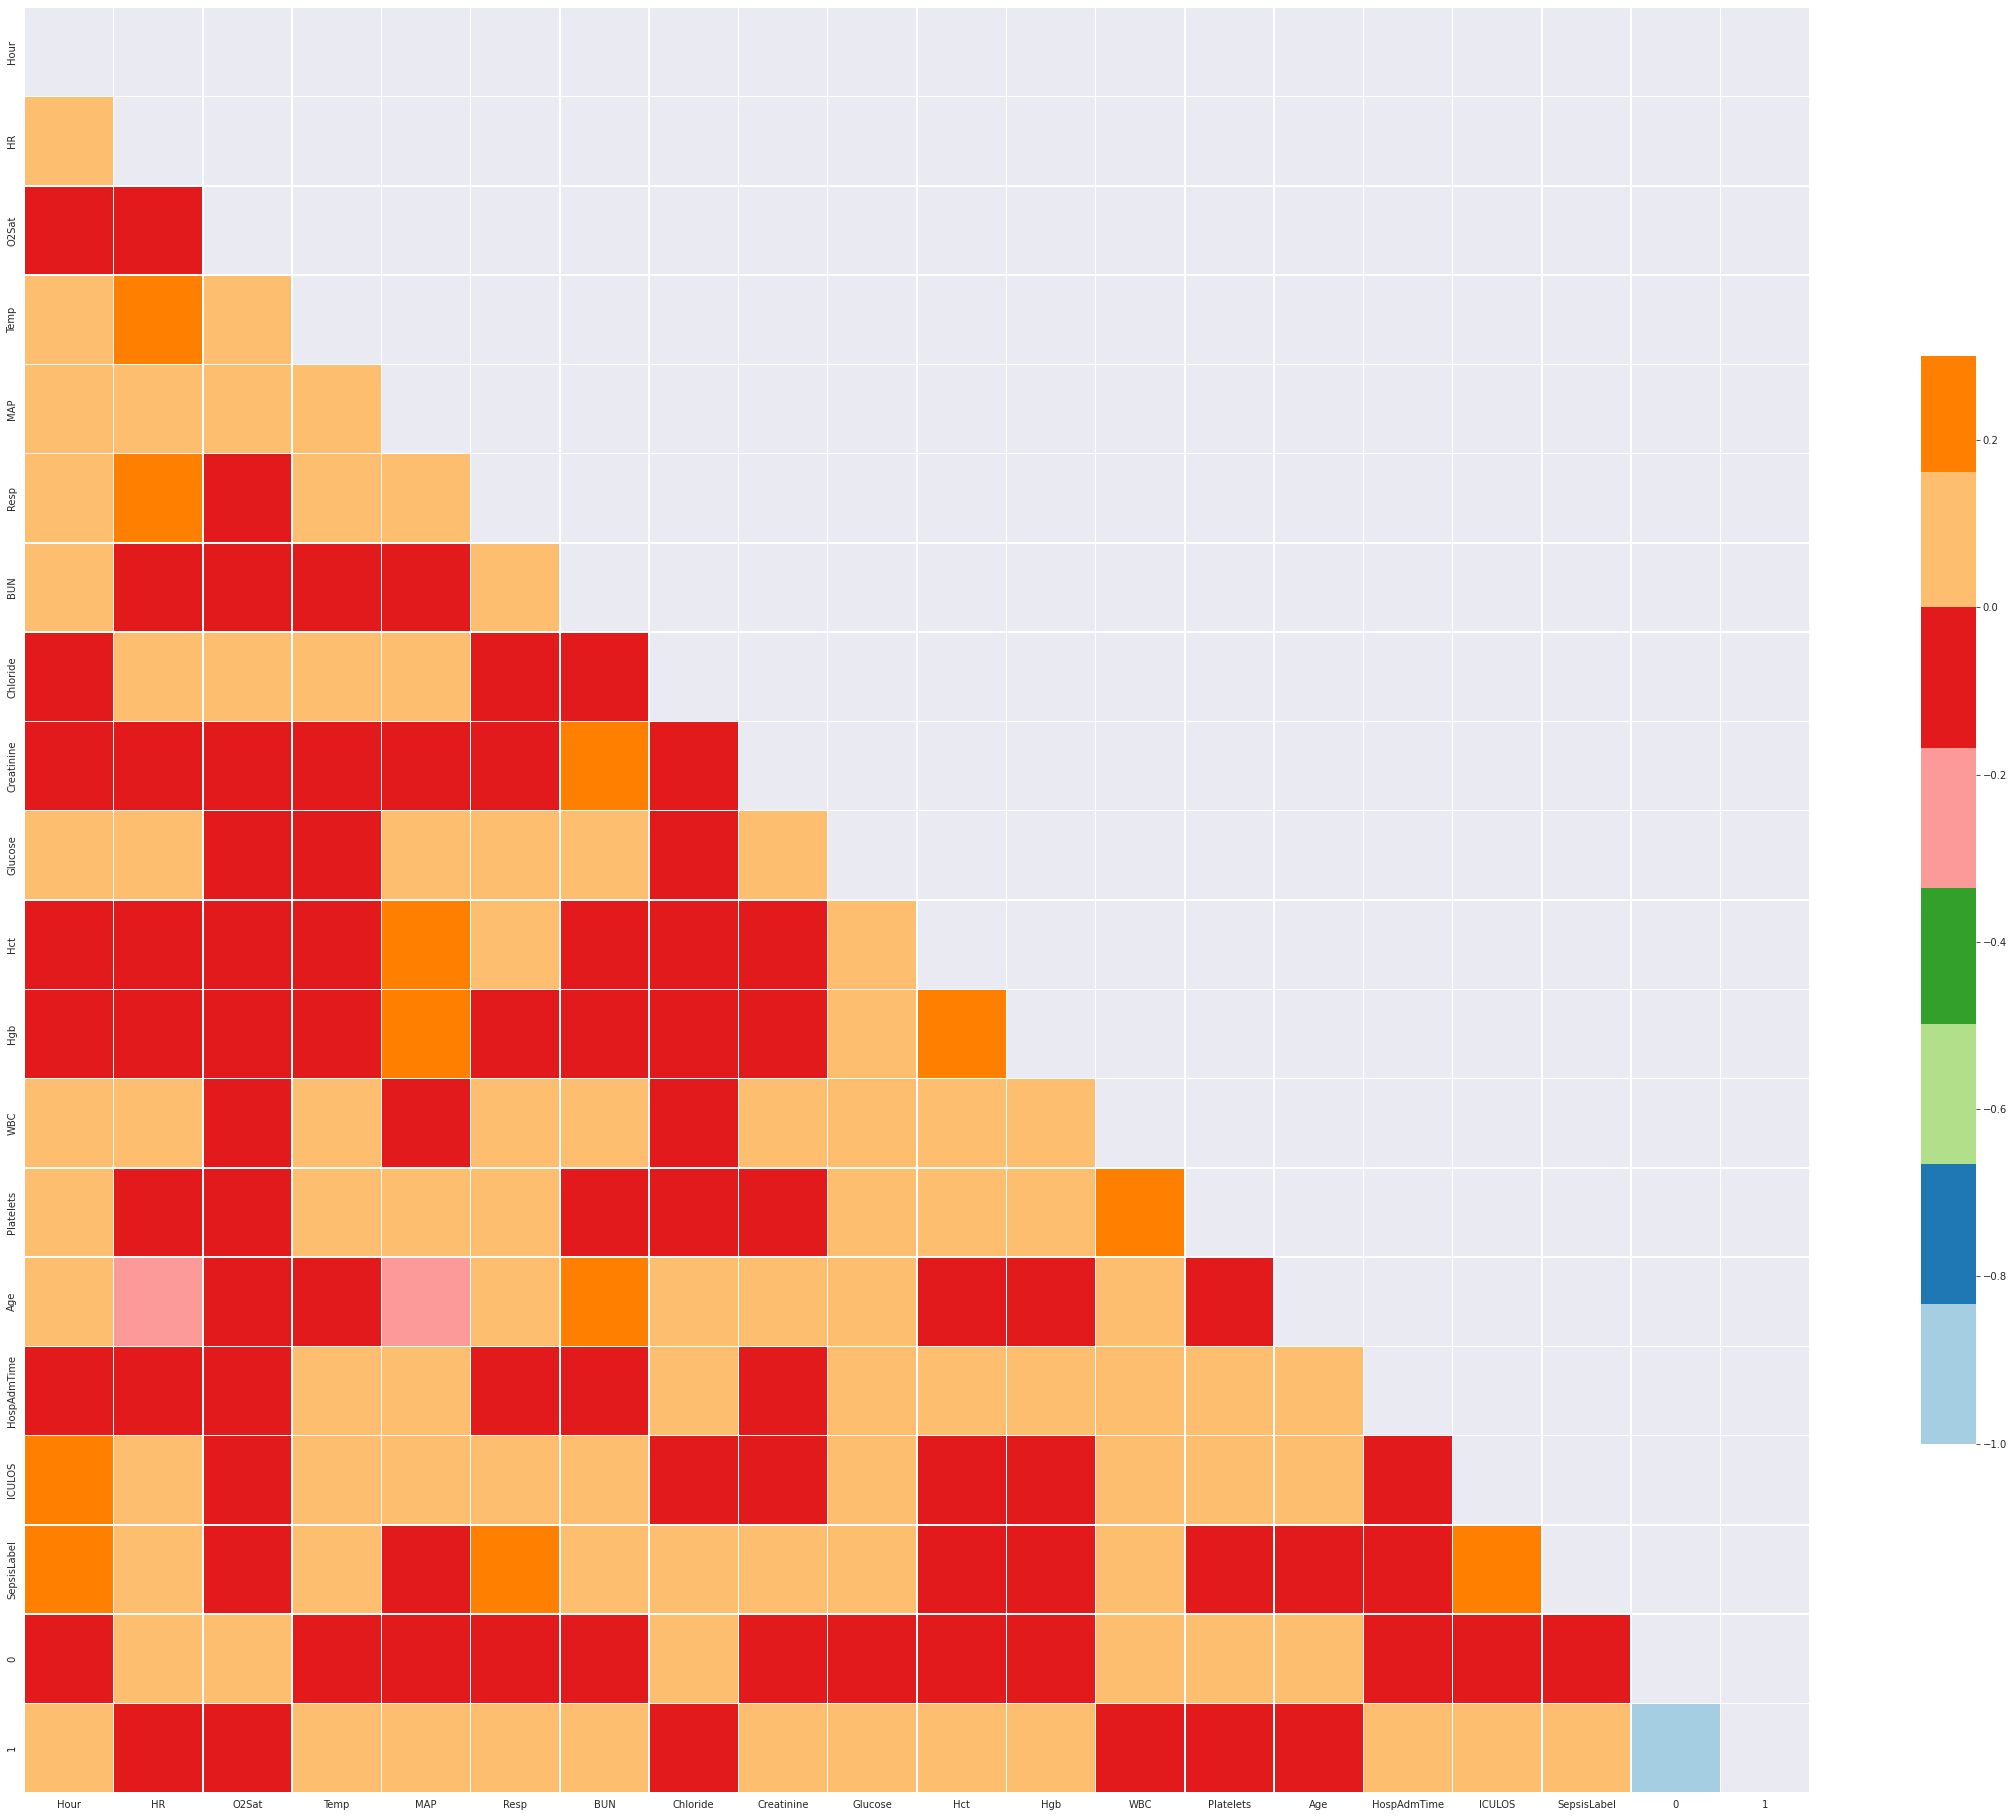

In [444]:
corr_matrix(df_train_impute)

## Randomforest

In [445]:
# train test split for the imputed output
X = df_train_impute.drop('SepsisLabel', axis=1)
y = df_train_impute['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [446]:
# random forest classifier
# random forest classifier was tested on different hyper parameters and it gave the best results with number of estimators as 300

# model = RandomForestClassifier(n_estimators=100, random_state=0)
# model = RandomForestClassifier(n_estimators=200, random_state=0)
model = RandomForestClassifier(n_estimators=300, random_state=0)
model.fit(X_train, y_train)
rcf_predictions = model.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Accuracy: 0.9574746483480536
Precision: 0.9252782193958664
Recall: 0.9494290375203915
F1 Score: 0.9371980676328502
AUC-ROC: 0.9554711515803727
Mean Absolute Error: 0.042525351651946354
Root Mean Squared Error: 0.20621675890175936


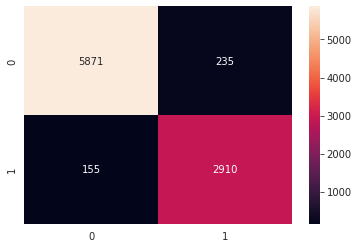

In [447]:
evaluate_model(y_test,rcf_predictions)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Accuracy: 0.7500817795224076
Precision: 0.7159763313609467
Recall: 0.430048465266559
F1 Score: 0.5373435607589827
AUC-ROC: 0.6715745947135955
Mean Absolute Error: 0.2499182204775924
Root Mean Squared Error: 0.499918213788608


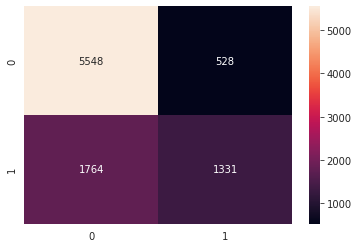

In [424]:
# Naive Bayes Classifier
# NBC performed worse than random forest on each and every aspect of the evaluation metrics

from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
nbc_predictions = model.predict(X_test)
evaluate_model(y_test,nbc_predictions)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Accuracy: 0.8158325155381092
Precision: 0.7727993655828708
Recall: 0.635889070146819
F1 Score: 0.6976910685519957
AUC-ROC: 0.7710234738221812
Mean Absolute Error: 0.18416748446189074
Root Mean Squared Error: 0.4291473924677753


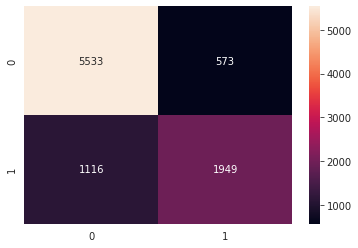

In [451]:
# KNN Classifier
# KNN was tested on different values of k

from sklearn.neighbors import KNeighborsClassifier
# model = KNeighborsClassifier(n_neighbors=8)
# model = KNeighborsClassifier(n_neighbors=5)
model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train, y_train)
knn_predictions = model.predict(X_test)
evaluate_model(y_test,knn_predictions)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Accuracy: 0.7533529604187111
Precision: 0.7588564325668117
Recall: 0.39450726978998385
F1 Score: 0.5191326530612245
AUC-ROC: 0.6653247343024968
Mean Absolute Error: 0.24664703958128883
Root Mean Squared Error: 0.49663572120950866


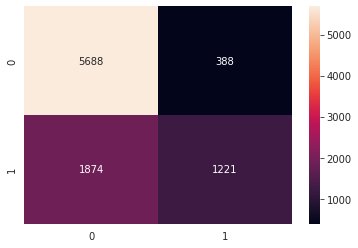

In [426]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
lr_predictions = model.predict(X_test)
evaluate_model(y_test,lr_predictions)

Accuracy: 0.8567222767419038
Precision: 0.8307517944843219
Recall: 0.7174551386623165
F1 Score: 0.7699579831932774
AUC-ROC: 0.8220423416862188
Mean Absolute Error: 0.14327772325809618
Root Mean Squared Error: 0.37852043968337584


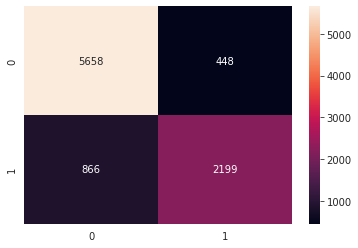

In [456]:
# XGBoost
# XGBoost was run for different combinations of hyperparameters, but overall random forest classifier performed the best in terms of F1 score and other metrics 

import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
param = {
    'max_depth': 5,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'binary:logistic'}  # error evaluation for binary classification
num_round = 100
bst = xgb.train(param, dtrain, num_round)
xgb_predictions = bst.predict(dtest)
prediction = []
for i in xgb_predictions:
  if i<0.5:
    prediction.append(0)
  else:
    prediction.append(1)
evaluate_model(y_test,prediction)

# Testing on the data of the other hospital

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Accuracy: 0.8770775297078337
Precision: 0.10098987876765654
Recall: 0.4635017866258295
F1 Score: 0.1658447488584475
AUC-ROC: 0.6758889482695134
Mean Absolute Error: 0.12292247029216628
Root Mean Squared Error: 0.3506030095309598


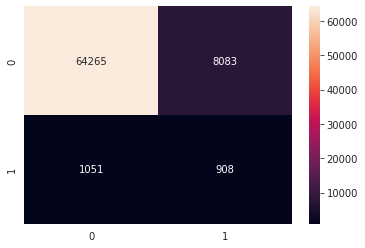

In [448]:
# testing on the other hospital data

df = get_data_ready(df_test)
X = df.drop('SepsisLabel', axis=1)
y = df['SepsisLabel']
rcf_predictions = model.predict(X)
evaluate_model(y,rcf_predictions)

In this notebook several models were built to predict the onset of sepsis 6 hours before. After deep analysis several features were dropped and the remaining were imputed. Then the remaining features were applied with gaussian transformation and then normalized, so that a sngle feature won't start dominating the output. After all this exploration and feature engineering, several classifier models were run, in which Random Forest Classifier gave the best results.